# Analisi spotify

## Preparazione dei dati per ML

In [19]:
# =====================================
# --- IMPORT LIBRARIES ---
# =====================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Feature Engineer

In [20]:
# %% 
# =====================================
# --- CARICAMENTO DATASET + FEATURE ENGINEERING ---
# =====================================
df = pd.read_csv("spotify_clean.csv")
TARGET = 'popularity'

# Drop colonne non utili
cols_to_drop = ['track_id','track_name','artist_name','album_name']
df = df.drop(columns=cols_to_drop)

# Trasformazione date
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['release_weekday'] = df['release_date'].dt.weekday
df['release_quarter'] = df['release_date'].dt.quarter
df['release_age'] = 2025 - df['release_year']

# Feature ingegnerizzate
df['dance_energy_product'] = df['danceability'] * df['energy']
df['dance_energy_ratio'] = df['danceability'] / (df['energy'] + 1e-5)
df['tempo_loudness_ratio'] = df['tempo'] / (df['loudness'] + 1e-5)
df['high_stream'] = (df['stream_count'] > df['stream_count'].median()).astype(int)
df['high_energy_fast'] = ((df['tempo']>140) & (df['energy']>0.7)).astype(int)
df['loudness_per_sec'] = df['loudness'] / (df['duration_s'])

# Interazioni
df['dance_x_loud'] = df['danceability'] * df['loudness_per_sec']
df['energy_x_tempo'] = df['energy'] * df['tempo']

# Categoriche derivate
df['tempo_cat'] = pd.cut(df['tempo'], bins=[0,80,140,250], labels=['slow','medium','fast'])
label_counts = df['label'].value_counts()
rare_labels = label_counts[label_counts<50].index
df['label_grouped'] = df['label'].replace(rare_labels,'Other')

# Drop colonne originarie non più necessarie
df = df.drop(columns=['release_date','mode','label','tempo','stream_count'])


## Preprocessing

In [21]:
# %% 
# =====================================
# --- PREPROCESSING ---
# =====================================
num_features = df.select_dtypes(include=['float64','int64']).columns.tolist()
num_features.remove(TARGET)
cat_features = df.select_dtypes(include=['object','category']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features)
])

X = df.drop(columns=[TARGET])
y = df[TARGET].reset_index(drop=True)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trasformazione
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre  = preprocessor.transform(X_test)


In [22]:
# %% 
# =====================================
# --- MODELLI BASE ---
# =====================================
models = {
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=12, max_features=0.7,
                                          random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=40,
                              max_depth=-1, subsample=0.8, colsample_bytree=0.8,
                              device='gpu', random_state=42),
    "CatBoost": CatBoostRegressor(iterations=300, depth=7, learning_rate=0.05,
                                  loss_function='RMSE', task_type='GPU', verbose=0, random_state=42)
}


In [23]:
# %% 
# =====================================
# --- ADDDESTRAMENTO MODELLI BASE ---
# =====================================
preds_train = {}
preds_test = {}
results = []

for name, model in tqdm(models.items(), desc="Addestramento modelli", unit="modello"):
    model.fit(X_train_pre, y_train)
    pred_train = model.predict(X_train_pre)
    pred_test  = model.predict(X_test_pre)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_test, pred_test))
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    
    preds_train[name] = pred_train
    preds_test[name] = pred_test
    results.append([name, rmse_train, rmse_test, r2_train, r2_test])

results_df = pd.DataFrame(results, columns=['Model','RMSE_Train','RMSE_Test','R2_Train','R2_Test'])
display(results_df)

Addestramento modelli:  33%|███▎      | 1/3 [00:34<01:09, 34.87s/modello]

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2567
[LightGBM] [Info] Number of data points in the train set: 67997, number of used features: 43
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (1.30 MB) transferred to GPU in 0.009141 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 48.020486


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Addestramento modelli: 100%|██████████| 3/3 [00:47<00:00, 15.87s/modello]


,Model,RMSE_Train,RMSE_Test,R2_Train,R2_Test
0,RandomForest,11.651210,12.137910,0.342572,0.281492
1,LightGBM,11.454460,12.166065,0.364588,0.278155
2,CatBoost,11.805907,12.144394,0.324999,0.280724


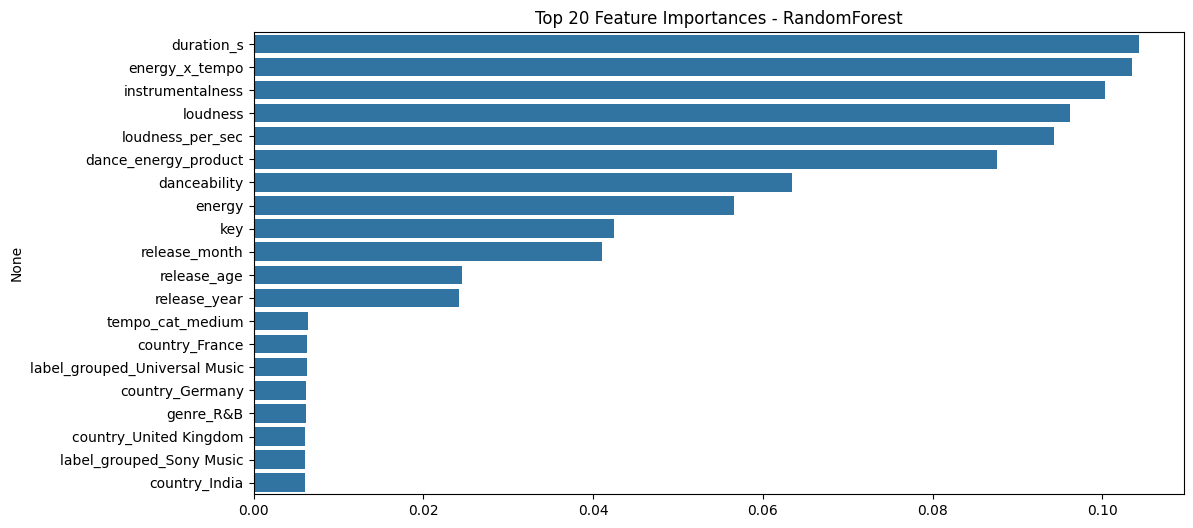

In [28]:
# Ottieni i nomi delle feature dopo OneHotEncoder
num_features = df.select_dtypes(include=['float64','int64']).columns.tolist()
num_features.remove(TARGET)
cat_features = df.select_dtypes(include=['object','category']).columns.tolist()

ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe.fit(df[cat_features])
cat_feature_names = ohe.get_feature_names_out(cat_features)

all_feature_names = num_features + list(cat_feature_names)

# Feature importance RandomForest
importances = models['RandomForest'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title("Top 20 Feature Importances - RandomForest")
plt.show()


In [31]:
import joblib

# Salviamo preprocessor + modelli
joblib.dump(preprocessor, "scaler_preprocessor.pkl")

# Se vuoi salvare i modelli base
joblib.dump(models['RandomForest'], "rf_model.pkl")
joblib.dump(models['LightGBM'], "lgbm_model.pkl")
joblib.dump(models['CatBoost'], "cat_model.pkl")


['cat_model.pkl']

In [32]:
# Salva le colonne finali dopo OneHotEncoding
X_columns = list(X_test.columns)
joblib.dump(X_columns, "X_columns.pkl")


['X_columns.pkl']